# Fig 1. vertical coordinates

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

import torch
from credit.boundary_padding import TensorPadding

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1.5
#mpl.rcParams['hatch.linewidth'] = 1.0

### Load config

In [4]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

### Load data

In [6]:
ds_static = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/static/ERA5_mlevel_1deg_static_subset.zarr'
)

ds_example = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_mlevel_1deg/all_in_one/ERA5_mlevel_1deg_6h_subset_1979_conserve.zarr'
)

grid_lat = ds_static['lat2d'].values
grid_lon = ds_static['lon2d'].values

In [7]:
coef_a = 0.01*ds_static['coef_a'].values
coef_b = ds_static['coef_b'].values

lat_val = grid_lat[48, 220:300][0]
lon_grids = grid_lon[48, 220:300]-360
SP = 0.01*ds_example['SP'].isel(time=0).values[48, 220:300]

coord_mlevel = np.empty((len(coef_a)-1, len(lon_grids)))

for i in range(len(coef_a)-1):
    pressure0 = coef_a[i] + coef_b[i] * SP
    pressure1 = coef_a[i+1] + coef_b[i+1] * SP
    coord_mlevel[i] = 0.5*(pressure0 + pressure1)

coord_plevel = np.array([1, 50, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000])

In [8]:
# per-level weights copied from YAML config

plevel_weights = np.array(
    [
        0.00016875, 0.00843739, 0.02531218, 0.03374958, 0.04218697, 0.10546743,
        0.16874789, 0.16874789, 0.16874789, 0.16874789, 0.16874789, 0.16874789, 0.16874789
    ]
) / 0.16874789 # <--- normalized to 0-1

mlevel_weights = np.array(
    [
        1.36577589e-06, 2.38872094e-05, 2.06553177e-04, 8.92194675e-04,
        2.53615808e-03, 5.55109728e-03, 1.02659148e-02, 1.74081408e-02,
        2.82033917e-02, 8.25636383e-02, 1.36923885e-01, 1.36923885e-01,
        1.36923885e-01, 1.36923885e-01, 1.36923885e-01, 1.36923885e-01,
        1.36923885e-01, 1.36923885e-01
    ]
) / 1.36923885e-01 # <--- normalized to 0-1

In [9]:
#cmap = cm.get_cmap('viridis')
def color_from_cmap(cmap, vmin, vmax, value):
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    return cmap(norm(value))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    # Create a set of values within [minval, maxval]
    new_colors = cmap(np.linspace(minval, maxval, n))

    # Create a new colormap from those values
    new_cmap = colors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        new_colors
    )
    return new_cmap

In [10]:
cmap = plt.get_cmap('RdBu_r', 13)
vmin = 0
vmax = 1.0

In [11]:
cmap_plot = truncate_colormap(cmap, minval=0.0, maxval=0.69)

In [12]:
norm = colors.Normalize(vmin=0, vmax=0.69)
cmap_plot_handle = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_plot)
cmap_plot_handle.set_array([])

### Plot

Text(0.4, -0.275, 'Normalized per-variable-level weights')

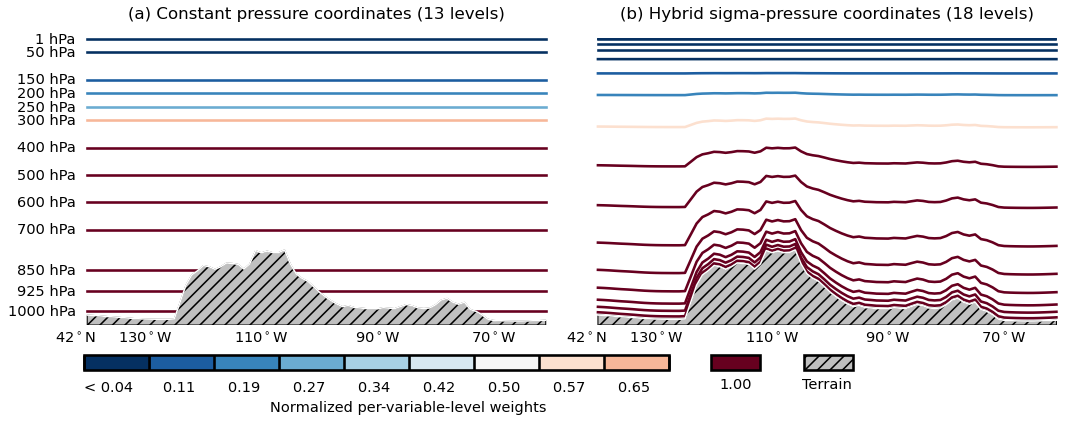

In [14]:
fake_y = np.ones(len(lon_grids))

fig = plt.figure(figsize=(13, 4), dpi=dpi_)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

AX = []
AX.append(plt.subplot(gs[0, 0]))
AX.append(plt.subplot(gs[0, 1]))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = gu.ax_decorate_box(ax)
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.set_ylim([-50, 1050])
    ax.set_yticks(coord_plevel)
    ax.invert_yaxis()
    ax.set_xlim([lon_grids[0]-0.5, lon_grids[-1]+0.5])
    ax.fill_between(lon_grids, SP, 1050, color='0.75', hatch='//', edgecolor='k', zorder=3)
    ax.plot(lon_grids, SP, color='w', zorder=4)

for i in range(len(coef_a)-1):
    color_ = color_from_cmap(cmap, vmin, vmax, mlevel_weights[i])
    if i < 4:
        AX[1].plot(lon_grids, coord_mlevel[i, :], color=color_, ls='-', lw=1.5, zorder=2)
    else:
        AX[1].plot(lon_grids, coord_mlevel[i, :], color=color_, ls='-', lw=2.5, zorder=2)

for i in range(len(coord_plevel)):
    color_ = color_from_cmap(cmap, vmin, vmax, plevel_weights[i])
    AX[0].plot(lon_grids, coord_plevel[i]*fake_y, color=color_, ls='-', lw=2.5, zorder=2)
    
    AX[0].text(lon_grids[0]-2, coord_plevel[i], f'{coord_plevel[i]} hPa', fontsize=14, ha='right', va='center')

AX[0].set_title('(a) Constant pressure coordinates (13 levels)', fontsize=16)
AX[1].set_title('(b) Hybrid sigma-pressure coordinates (18 levels)', fontsize=16)

label_lon = [-130, -110, -90, -70]
for i_label, lon in enumerate(label_lon):
    AX[0].text(lon, 1050+20, '{}$^\circ$W'.format(-1*lon), va='top', ha='center', fontsize=14)
    AX[1].text(lon, 1050+20, '{}$^\circ$W'.format(-1*lon), va='top', ha='center', fontsize=14)
    
AX[0].text(-142, 1050+20, '42$^\circ$N', va='top', ha='center', fontsize=14)
AX[1].text(-142, 1050+20, '42$^\circ$N', va='top', ha='center', fontsize=14)

ticks = np.linspace(0, 0.69, 10)
ticks_mid = 0.5*(ticks[1:]+ticks[:-1])
ticklabels = [f"{t:7.2f}" for t in ticks_mid]
ticklabels.append(' ')
ticklabels[0] = '< 0.04'
#ticklabels[1::2] = [' ',]*6
ax_base = fig.add_axes([0, -0.2, 0.6, 0.1])
[j.set_linewidth(1.0) for j in ax_base.spines.values()]
ax_base.set_axis_off()
ax_base.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(
    cmap_plot_handle, 
    orientation='horizontal', 
    cax=cax, 
    ticks=ticks, 
)
CBar.set_ticklabels(ticklabels, x=1, ha='left')
CBar.ax.tick_params(pad=10)
CBar.ax.tick_params(axis='x', labelsize=14, width=2.5, direction='in', length=14)
CBar.outline.set_linewidth(2.5)

handle_lg = []
handle_lg.append(patches.Patch(linewidth=3, edgecolor='k', facecolor='none', label=''))

rect1 = patches.Rectangle(
    (0.25, -0.15), 0.105, 0.05,
    linewidth=2.5,
    edgecolor='k',
    facecolor=color_,
    transform=AX[1].transAxes,  
    clip_on=False
)

AX[1].add_patch(rect1)


rect2 = patches.Rectangle(
    (0.45, -0.15), 0.105, 0.05,
    linewidth=2.5,
    edgecolor='k',
    facecolor='0.75',
    hatch='//',
    transform=AX[1].transAxes,  
    clip_on=False
)

AX[1].add_patch(rect2)
AX[1].text(0.3025, -0.1975, '1.00', ha='center', va='center', fontsize=14, transform=AX[1].transAxes)
AX[1].text(0.5, -0.1975, 'Terrain', ha='center', va='center', fontsize=14, transform=AX[1].transAxes)

AX[0].text(
    0.4, -0.275, 
    'Normalized per-variable-level weights', 
    ha='left', va='center', fontsize=14, transform=AX[0].transAxes
)

## Plot (larger version, X)

In [ ]:
# fake_y = np.ones(len(lon_grids))

# fig = plt.figure(figsize=(13, 5), dpi=dpi_)
# gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# AX = []
# AX.append(plt.subplot(gs[0, 0]))
# AX.append(plt.subplot(gs[0, 1]))
# plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

# for ax in AX:
#     ax = gu.ax_decorate_box(ax)
#     [j.set_linewidth(0) for j in ax.spines.values()]
#     ax.set_ylim([-50, 1050])
#     ax.set_yticks(coord_plevel)
#     ax.invert_yaxis()
#     ax.set_xlim([lon_grids[0]-0.5, lon_grids[-1]+0.5])
#     ax.fill_between(lon_grids, SP, 1050, color='0.75', hatch='//', edgecolor='k', zorder=3)
#     ax.plot(lon_grids, SP, color='w', zorder=4)

# for i in range(len(coef_a)-1):
#     color_ = color_from_cmap(cmap, vmin, vmax, mlevel_weights[i])
#     if i < 4:
#         AX[1].plot(lon_grids, coord_mlevel[i, :], color=color_, ls='-', lw=1.5, zorder=2)
#     else:
#         AX[1].plot(lon_grids, coord_mlevel[i, :], color=color_, ls='-', lw=3.5, zorder=2)
        
#     # if i == len(coef_a)-2:
#     #     AX[1].fill_between(lon_grids, coord_mlevel[i, :], 1050, color=color_, zorder=1)
#     # else:
#     #     AX[1].fill_between(lon_grids, coord_mlevel[i, :], coord_mlevel[i+1, :], color=color_, zorder=1)

# for i in range(len(coord_plevel)):
#     color_ = color_from_cmap(cmap, vmin, vmax, plevel_weights[i])
#     AX[0].plot(lon_grids, coord_plevel[i]*fake_y, color=color_, ls='-', lw=3.5, zorder=2)
    
#     AX[0].text(lon_grids[0]-2, coord_plevel[i], f'{coord_plevel[i]} hPa', fontsize=16, ha='right', va='center')
#     # if i == len(coord_plevel)-1:
#     #     AX[0].fill_between(lon_grids, coord_plevel[i]*fake_y, 1050, color=color_, zorder=1)
#     # else:
#     #     AX[0].fill_between(lon_grids, coord_plevel[i]*fake_y, coord_plevel[i+1]*fake_y, color=color_, zorder=1)

# AX[0].set_title('(a) Constant pressure coordinates (13 levels)', fontsize=16)
# AX[1].set_title('(b) Hybrid sigma-pressure coordinates (18 levels)', fontsize=16)

# label_lon = [-130, -110, -90, -70]
# for i_label, lon in enumerate(label_lon):
#     AX[0].text(lon, 1050+20, '{}$^\circ$W'.format(-1*lon), va='top', ha='center', fontsize=16)
#     AX[1].text(lon, 1050+20, '{}$^\circ$W'.format(-1*lon), va='top', ha='center', fontsize=16)
    
# AX[0].text(-142, 1050+20, '42$^\circ$N', va='top', ha='center', fontsize=16)
# AX[1].text(-142, 1050+20, '42$^\circ$N', va='top', ha='center', fontsize=16)

# ticks = np.linspace(0, 0.69, 10)
# ticks_mid = 0.5*(ticks[1:]+ticks[:-1])
# ticklabels = [f"{t:7.2f}" for t in ticks_mid]
# ticklabels.append(' ')
# ticklabels[0] = '< 0.04'
# #ticklabels[1::2] = [' ',]*6
# ax_base = fig.add_axes([0, -0.2, 0.6, 0.1])
# [j.set_linewidth(1.0) for j in ax_base.spines.values()]
# ax_base.set_axis_off()
# ax_base.tick_params(
#     axis='both', left=False, top=False, right=False, bottom=False, 
#     labelleft=False, labeltop=False, labelright=False, labelbottom=False
# )
# cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
# CBar = plt.colorbar(
#     cmap_plot_handle, 
#     orientation='horizontal', 
#     cax=cax, 
#     ticks=ticks, 
# )
# CBar.set_ticklabels(ticklabels, x=1, ha='left')
# CBar.ax.tick_params(pad=10)
# CBar.ax.tick_params(axis='x', labelsize=16, width=2.5, direction='in', length=16)
# CBar.outline.set_linewidth(2.5)

# handle_lg = []
# handle_lg.append(patches.Patch(linewidth=3, edgecolor='k', facecolor='none', label=''))

# rect1 = patches.Rectangle(
#     (0.25, -0.15), 0.105, 0.05,
#     linewidth=2.5,
#     edgecolor='k',
#     facecolor=color_,
#     transform=AX[1].transAxes,  
#     clip_on=False
# )

# AX[1].add_patch(rect1)


# rect2 = patches.Rectangle(
#     (0.45, -0.15), 0.105, 0.05,
#     linewidth=2.5,
#     edgecolor='k',
#     facecolor='0.75',
#     hatch='//',
#     transform=AX[1].transAxes,  
#     clip_on=False
# )

# AX[1].add_patch(rect2)
# AX[1].text(0.3025, -0.1975, '1.00', ha='center', va='center', fontsize=16, transform=AX[1].transAxes)
# AX[1].text(0.5, -0.1975, 'Terrain', ha='center', va='center', fontsize=16, transform=AX[1].transAxes)

# AX[0].text(
#     0.4, -0.275, 
#     'Normalized per-variable-level weights', 
#     ha='left', va='center', fontsize=16, transform=AX[0].transAxes
# )